<a href="https://colab.research.google.com/github/DineshKesawamoorthy/nlp/blob/main/Sentiment_Analysis_with_transformers_and_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Steps :
1. Download and import Required libraries
2. Data Preprocessing
3. TensorFlow Input Pipeline
4. Building and Training
5. Making Predictions


In [11]:
import transformers

# Getting the data from Kaggle API

In [12]:
! pip install -q kaggle


In [15]:
with open('/root/.kaggle/kaggle.json','w') as f:
  f.write("""""")

In [16]:
! chmod 600 ~/.kaggle/kaggle.json

In [17]:
import kaggle

In [18]:
 ! kaggle datasets list

ref                                                              title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rahulvyasm/netflix-movies-and-tv-shows                           Netflix Movies and TV Shows                        1MB  2024-04-10 09:48:38          15458        325  1.0              
sahirmaharajj/school-student-daily-attendance                    School Student Daily Attendance                    2MB  2024-04-29 19:29:56           2921         58  1.0              
mexwell/heart-disease-dataset                                    🫀 Heart Disease Dataset                          399KB  2024-04-08 09:43:49           7032        110  1.0              
kapturovalexander/time-series-for-online-store                   🏪🏬🪫 E

In [19]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [20]:
api= KaggleApi()
api.authenticate()

In [21]:
api.competition_download_file('sentiment-analysis-on-movie-reviews','test.tsv.zip',path='./')
api.competition_download_file('sentiment-analysis-on-movie-reviews','train.tsv.zip',path='./')

100%|██████████| 494k/494k [00:00<00:00, 68.5MB/s]

100%|██████████| 1.28M/1.28M [00:00<00:00, 81.4MB/s]

In [22]:
import zipfile

In [23]:
with zipfile.ZipFile('./test.tsv.zip','r') as zipref:
  zipref.extractall('./')

In [24]:
with zipfile.ZipFile('./train.tsv.zip','r') as zipref:
  zipref.extractall('./')

# Read the Data using pandas

In [25]:
import pandas as pd


In [26]:
df_movies= pd.read_csv('train.tsv',sep='\t')
df_movies

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


<Axes: xlabel='Sentiment'>

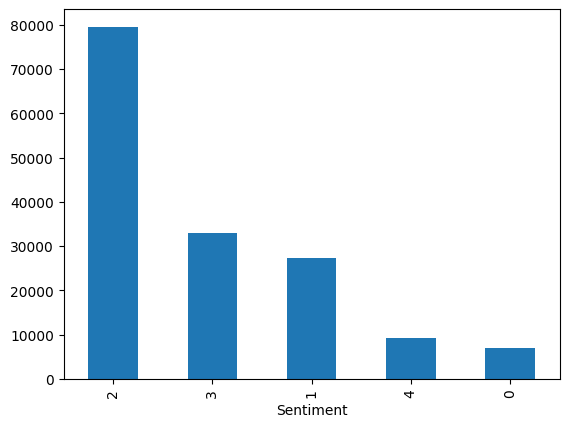

In [27]:
df_movies['Sentiment'].value_counts().plot(kind='bar')

In [28]:
seq_len=512 # BERT
num_samples= len(df_movies)
print(seq_len,num_samples)
seq_len,num_samples

512 156060


(512, 156060)

# Loading Tokenizer from Hugging Face

In [29]:
from transformers import BertTokenizer

In [30]:
tokenizer= BertTokenizer.from_pretrained('bert-base-cased')
tokenizer

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

BertTokenizer(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [31]:
tokens= tokenizer(df_movies.Phrase.tolist(),max_length=seq_len,truncation=True,padding='max_length',add_special_tokens=True,return_tensors='np')

In [32]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [33]:
tokens['input_ids']

array([[  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       ...,
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101, 22572, 12148, ...,     0,     0,     0]])

In [34]:
tokens['attention_mask']

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

# Importing Numpy and saving inputids & attention mask

In [36]:
import numpy as np

In [63]:
with open("movie-xids.npy",'wb') as f:
  np.save(f,tokens['input_ids'])
with open("movie-attention-mask.npy",'wb') as f:
  np.save(f,tokens['attention_mask'])

In [42]:
arr=df_movies.Sentiment.values
arr

array([1, 2, 2, ..., 3, 2, 2])

In [43]:
arr.shape

(156060,)

In [44]:
arr.max()

4

In [55]:
labels= np.zeros((num_samples,arr.max()+1))
labels

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [56]:
labels.shape

(156060, 5)

In [57]:
labels[np.arange(num_samples),arr] = 1

In [59]:
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [60]:
with open('novie-labels.npy','wb') as f:
  np.save(f,labels)

# Buliding DataSet

In [61]:
import numpy as np


In [64]:
with open("movie-xids.npy",'rb') as f:
  Xids=np.load(f,allow_pickle=True)
with open("movie-attention-mask.npy",'rb') as f:
  Xmask=np.load(f,allow_pickle=True)
with open("novie-labels.npy",'rb') as f:
  labels=np.load(f,allow_pickle=True)

In [65]:
Xids.shape

(156060, 512)

In [66]:
Xmask.shape

(156060, 512)

In [67]:
labels.shape

(156060, 5)

In [68]:
import tensorflow as tf


In [76]:
dataset=tf.data.Dataset.from_tensor_slices((Xids,Xmask,labels))
dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.int64, name=None), TensorSpec(shape=(512,), dtype=tf.int64, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [77]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.int64, name=None), TensorSpec(shape=(512,), dtype=tf.int64, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

{input_ids,mask}, labels

In [72]:
def map_func(input_ids,masks, labels):
  return {'input_ids': input_ids,
          'attention_mask': masks} , labels

In [78]:
dataset=dataset.map(map_func)
dataset

<_MapDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.int64, name=None)}, TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [79]:
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.int64, name=None)}, TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

# Tensorflow Dataset shuffle, Batch, Split and Save Operations

In [80]:
batch_size=16

In [84]:
dataset=dataset.shuffle(10000).batch(batch_size,drop_remainder=True)
dataset

<_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

In [85]:
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

In [86]:
split=0.9 # 90% of data

In [90]:
size= int (Xids.shape[0]/ batch_size * split)
size

8778

In [93]:
train_ds= dataset.take(size)
val_ds=dataset.skip(size)

In [94]:
tf.data.experimental.save(train_ds, 'train')
tf.data.experimental.save(val_ds, 'val')

In [95]:
tf.data.Dataset.save(train_ds, 'train') # if previous one depreciated
tf.data.Dataset.save(val_ds, 'val')# if previous one depreciated

In [100]:
train_ds.element_spec

({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
  'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)},
 TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

In [101]:
val_ds.element_spec

({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
  'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)},
 TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

In [102]:
train_ds.element_spec == val_ds.element_spec

True

In [104]:
ds=tf.data.Dataset.load('train',element_spec=train_ds.element_spec)
ds.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

# Build and Save TF models

In [109]:
!pip install transformers[tensorflow]

In [ ]:
from transformers import TFAutoModel # TFAutomodel will throw error
#from transformers import BertModel

In [143]:
model = TFAutoModel.from_pretrained('bert-base-uncased')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [144]:
model.summary()

Model: "tf_bert_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109482240 (417.64 MB)
Trainable params: 109482240 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [148]:
import tensorflow as tf

# Define input layers
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')

# BERT model
bert_output = model.bert(input_ids,attention_mask=mask)

# Extract embeddings
embeddings = bert_output[1]

# Classifier head
x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(x)

TypeError: Exception encountered when calling layer 'embeddings' (type TFBertEmbeddings).

Could not build a TypeSpec for name: "tf.debugging.assert_less_11/assert_less/Assert/Assert"
op: "Assert"
input: "tf.debugging.assert_less_11/assert_less/All"
input: "tf.debugging.assert_less_11/assert_less/Assert/Assert/data_0"
input: "tf.debugging.assert_less_11/assert_less/Assert/Assert/data_1"
input: "tf.debugging.assert_less_11/assert_less/Assert/Assert/data_2"
input: "Placeholder"
input: "tf.debugging.assert_less_11/assert_less/Assert/Assert/data_4"
input: "tf.debugging.assert_less_11/assert_less/y"
attr {
  key: "T"
  value {
    list {
      type: DT_STRING
      type: DT_STRING
      type: DT_STRING
      type: DT_INT32
      type: DT_STRING
      type: DT_INT32
    }
  }
}
attr {
  key: "summarize"
  value {
    i: 3
  }
}
 of unsupported type <class 'tensorflow.python.framework.ops.Operation'>.

Call arguments received by layer 'embeddings' (type TFBertEmbeddings):
  • input_ids=<KerasTensor: shape=(None, 512) dtype=int32 (created by layer 'input_ids')>
  • position_ids=None
  • token_type_ids=<KerasTensor: shape=(None, 512) dtype=int32 (created by layer 'tf.fill_11')>
  • inputs_embeds=None
  • past_key_values_length=0
  • training=False

In [149]:
model= tf.keras.Model(inputs=[input_ids,mask],output=y)

NameError: name 'y' is not defined

In [150]:
model.summary()

Model: "tf_bert_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109482240 (417.64 MB)
Trainable params: 109482240 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [154]:
model.layers[2].trainable=False

IndexError: list index out of range

In [158]:
optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5)
loss=tf.keras.losses.CategoricalCrossentropy()
acc=tf.keras.metrics.CategoricalAccuracy('accuracy')


In [160]:
model.compile(optimizer=optimizer,loss=loss,metrics=[acc])

ValueError: Could not interpret optimizer identifier: <keras.src.optimizers.adam.Adam object at 0x7951cf426fe0>

In [161]:
element_spec= ({'input_ids': tf.TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
  'attention_mask': tf.TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)},
 tf.TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

In [162]:
train_ds=tf.data.experimental.load('train',element_spec=element_spec)

Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


In [163]:
val_ds=tf.data.experimental.load('val',element_spec=element_spec)

In [164]:
train_ds.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

In [165]:
history=model.fit(
    train_ds,vaildation_data=val_ds,epochs=3
)

TypeError: Model.fit() got an unexpected keyword argument 'vaildation_data'

In [167]:
model.save('sentiment_model')

# Loading the saved model and prediction

In [166]:
model=tf.keras.models.load_model('sentiment_model')

OSError: No file or directory found at sentiment_model

In [168]:
from transformers import BertTokenizer


In [171]:
tokenizer=BertTokenizer.from_pretrained('bert-base-cased')


In [172]:
def prep_data(text):
  tokens=tokenizer(text,max_length=512,truncation=True,padding='max_length',add_special_tokens=True,return_tensors='tf')
  return {'input_ids':tokens['input_ids'],'attention_mask':tokens['attention_mask']}

In [178]:
prep_data("Hello World ")

{'input_ids': <tf.Tensor: shape=(1, 512), dtype=int32, numpy=
 array([[ 101, 8667, 1291,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,

In [179]:
model.predict(prep_data("Hello World "))

1/1 [==============================] - 16s 16s/step


TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=array([[[-0.45197535,  0.2483873 , -0.20036656, ...,  0.0072507 ,
          0.12246914,  0.20054957],
        [ 0.33482298,  0.11807593,  0.21996456, ...,  0.00709011,
          0.03612965, -0.37721255],
        [-0.05311048, -0.63693476, -0.36847565, ...,  0.71880436,
          0.32234126,  0.09607457],
        ...,
        [ 0.07086658, -0.10035587, -0.01526077, ...,  0.06941726,
         -0.05141668,  0.02715018],
        [ 0.06475095, -0.05074577,  0.02600917, ...,  0.05890345,
         -0.00986069,  0.05287699],
        [-0.15893774, -0.21850324, -0.07451557, ...,  0.17326677,
         -0.08698234,  0.06088393]]], dtype=float32), pooler_output=array([[-9.14321542e-01, -2.27392331e-01, -8.30554590e-02,
         7.97531784e-01,  1.81754977e-01, -1.78960785e-01,
         9.52383876e-01,  1.99377000e-01, -2.38093883e-01,
        -9.99973238e-01, -2.52950162e-01,  6.49049044e-01,
         9.74359810e-01,  1.45851344e-01, 

In [183]:
probs=model.predict(prep_data("Hello World "))[0]
probs

1/1 [==============================] - 2s 2s/step


array([[[-0.45197535,  0.2483873 , -0.20036656, ...,  0.0072507 ,
          0.12246914,  0.20054957],
        [ 0.33482298,  0.11807593,  0.21996456, ...,  0.00709011,
          0.03612965, -0.37721255],
        [-0.05311048, -0.63693476, -0.36847565, ...,  0.71880436,
          0.32234126,  0.09607457],
        ...,
        [ 0.07086658, -0.10035587, -0.01526077, ...,  0.06941726,
         -0.05141668,  0.02715018],
        [ 0.06475095, -0.05074577,  0.02600917, ...,  0.05890345,
         -0.00986069,  0.05287699],
        [-0.15893774, -0.21850324, -0.07451557, ...,  0.17326677,
         -0.08698234,  0.06088393]]], dtype=float32)

In [181]:
import numpy as np

In [184]:
np.argmax(probs)

205

In [187]:
for i, row in df_movies.iterrows():
  tokens=prep_data(row['Phrase'])
  probs=model.predict(tokens)
  pred=np.argmax(probs)
  df_movies.at[i,'Sentiment']=pred

1/1 [==============================] - 2s 2s/step


KeyboardInterrupt: 

In [188]:
df_movies

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,0
1,2,1,A series of escapades demonstrating the adage ...,0
2,3,1,A series,0
3,4,1,A,0
4,5,1,series,0
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2
